In [7]:
import torch
from abslrp_gae.abslrp.rules.models import VGGAbsLRPRule, ResNetAbsLRPRule, VisionTransformerAbsLRPRule
from abslrp_gae.abslrp.relevancy_methods import AbsLRPRelevancyMethod
from abslrp_gae.utils import preprocess_image, visualize_batch
import timm
from timm.models.vision_transformer import VisionTransformer
from PIL import Image

# load the model
device = "cuda"
model = timm.create_model("vit_base_patch16_224", pretrained=True)
# model = timm.create_model("vgg16", pretrained=True)
# model = timm.create_model("resnet50", pretrained=True)
model.eval()
model.to(device)

# apply the absLRP rule to the model
VisionTransformerAbsLRPRule().apply(model)
# VGGAbsLRPRule().apply(model)
# ResNetAbsLRPRule().apply(model)

# calculate relevancy
relevancy_method = AbsLRPRelevancyMethod(model, device)
is_vit = isinstance(model, VisionTransformer)
x = torch.stack(
    [
        preprocess_image(Image.open("images/dog_cat.jpeg").convert("RGB"), is_vit),
        preprocess_image(Image.open("images/hedgehog.jpg").convert("RGB"), is_vit),
    ],
    0,
)
relevance = relevancy_method.relevancy(x)

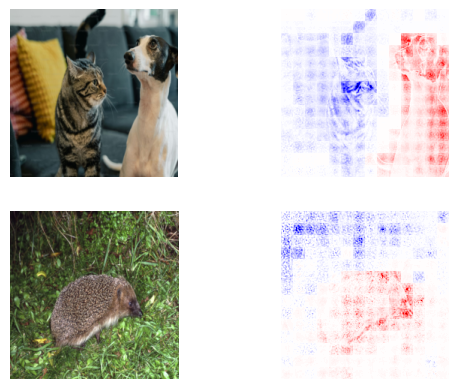

In [8]:
# visualize relevance maps
visualize_batch(x, relevance, is_vit)

In [9]:
from datasets import load_dataset
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
    IMAGENET_INCEPTION_MEAN,
    IMAGENET_INCEPTION_STD,
)
from torch.utils.data import Dataset, DataLoader

USE_IMAGENET_DATASET = True
MODEL_TYPE = "VGG"


class HFDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()

        self.dataset = dataset

    def __getitem__(self, index):
        data = self.dataset[index]
        return data["pixel_values"], data["label"]

    def __len__(self):
        return len(self.dataset)


def transforms(examples):
    examples["pixel_values"] = [transforms_list(image.convert("RGB")) for image in examples["image"]]
    return examples


transforms_list = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
        Normalize(
            mean=IMAGENET_DEFAULT_MEAN if MODEL_TYPE != "VIT" else IMAGENET_INCEPTION_MEAN,
            std=IMAGENET_DEFAULT_STD if MODEL_TYPE != "VIT" else IMAGENET_INCEPTION_STD,
        ),
    ]
)

if USE_IMAGENET_DATASET:
    dataset = {}
    for split in ["train", "validation", "test"]:
        dataset[split] = load_dataset("ILSVRC/imagenet-1k", trust_remote_code=True, split=split)

    dataset["train"].set_transform(transforms)
    dataset["validation"].set_transform(transforms)
    dataset["test"].set_transform(transforms)

    train_dataset = HFDataset(dataset["train"])
    validation_dataset = HFDataset(dataset["validation"])

In [14]:
dataset = torch.utils.data.Subset(validation_dataset, list(range(128)))

In [ ]:
from abslrp_gae.gae.gae import GlobalEvaluationMetric

metric = GlobalEvaluationMetric()

relevancy_methods = {
    "abslrp": relevancy_method,
}

results = metric.run(
    relevancy_methods=relevancy_methods,
    model=model,
    dataset=dataset,
    batch_size=8,
)

100%|██████████| 16/16 [02:29<00:00,  9.31s/it]


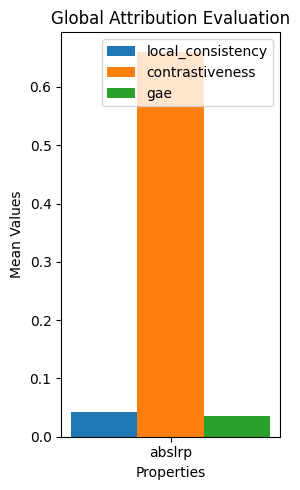

In [16]:
metric.plot()

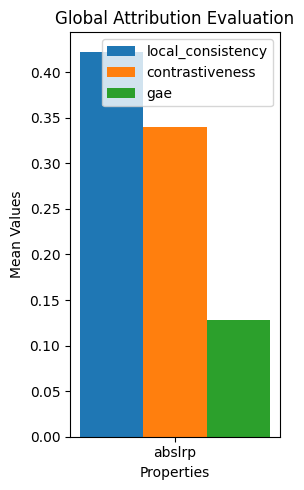

In [6]:
metric.plot()

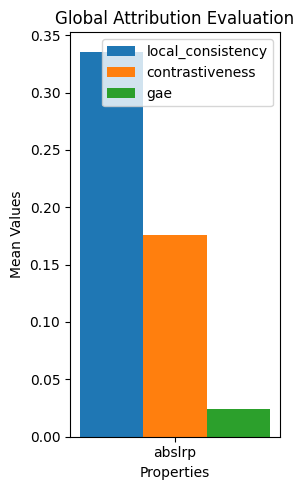

In [ ]:
metric.plot()

In [31]:
torch.randint(high=4, size=(2,))

tensor([0, 3])

In [ ]:
x_batch = torch.randn(8, 3, 224, 224)
batch_size, _, height, width = x_batch.shape
num_mosaics = batch_size // 4

nfeats = 1000

o_batch = torch.randn(8, 1000)
pred_batch = o_batch.max(-1)[1]
o_mosaic = torch.randn(2, 1000)
expanded_o_mosaic = o_mosaic[:, None].repeat(1, 4, 1).reshape(batch_size, -1)
mosaic_prediction_distribution = (
    expanded_o_mosaic[torch.arange(batch_size), pred_batch].reshape(num_mosaics, -1).softmax(-1)
)

torch.multinomial(mosaic_prediction_distribution, num_samples=1).flatten()

tensor([3, 1])

In [44]:
mosaic_max_predictions

tensor([[0.1676, 0.0239, 0.7249, 0.0836],
        [0.4261, 0.0820, 0.3464, 0.1456]])

In [40]:
o_mosaic, o_mosaic[:, None].repeat(1, 2, 1).reshape(4, -1)

(tensor([[ 1.3445, -0.6083, -0.4113],
         [ 0.1478,  0.2061, -0.5138]]),
 tensor([[ 1.3445, -0.6083, -0.4113],
         [ 1.3445, -0.6083, -0.4113],
         [ 0.1478,  0.2061, -0.5138],
         [ 0.1478,  0.2061, -0.5138]]))